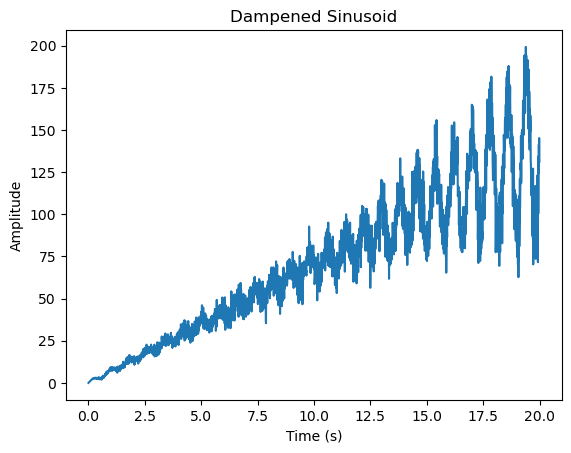

In [28]:
import numpy as np
#Import the Generator from utils- Reload the module to get the latest version
from importlib import reload
import utils
reload(utils)
from utils import series_generator
from utils import stock_price_generator
import matplotlib.pyplot as plt




#Simulate and plot a dampened sinusoid in time



#Genrate the series or download stock data

y, y_train, y_test, t = series_generator(2500)
#y, y_train, y_test, t = stock_price_generator('^VIX')
T, T_train, T_test = len(y), len(y_train), len(y_test)



# Plot the function
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dampened Sinusoid')
plt.show()



In [29]:
import Models
reload(Models)
from Models import Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#Preprocess the data to normalize them using the training statistics

y_train_zscore = (y_train - np.mean(y_train)) / np.std(y_train)
y_zscore = (y - np.mean(y_train)) / np.std(y_train)


#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
net.train()

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train_zscore[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train_zscore[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1] loss: 14.1790468302
[2] loss: 4.2214218602
[3] loss: 5.0571866818
[4] loss: 4.1417082511
[5] loss: 10.7495142967
[6] loss: 2.4082257953
[7] loss: 3.8117986023
[8] loss: 1.9943803754
[9] loss: 4.7403346989
[10] loss: 3.6623511966
[11] loss: 8.7719102334
[12] loss: 1.8314093966
[13] loss: 3.0571445273
[14] loss: 4.8174470346
[15] loss: 4.6741008833
[16] loss: 4.6922137905
[17] loss: 1.8162947372
[18] loss: 3.1745023476
[19] loss: 1.6517713508
[20] loss: 2.7333428087
[21] loss: 1.9036114952
[22] loss: 4.2362682521
[23] loss: 1.4137817025
[24] loss: 2.1583469864
[25] loss: 1.4508263636
[26] loss: 2.3081324399
[27] loss: 1.3822080567
[28] loss: 2.1870470885
[29] loss: 1.3291931464
[30] loss: 2.0452960539
[31] loss: 1.2371822353
[32] loss: 1.8763290332
[33] loss: 1.2098036241
[34] loss: 1.8627403397
[35] loss: 1.2451382391
[36] loss: 2.0543676475
[37] loss: 1.2882163897
[38] loss: 2.1601912826
[39] loss: 1.2469592439
[40] loss: 2.1077848114
[41] loss: 1.2409801483
[42] loss: 1.9130880777

In [30]:
#Test the model on the entire data set and plot the results.
net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y_zscore[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)
#Denormalize the prediction
y_pred = y_pred*np.std(y_train) + np.mean(y_train)


#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)


279.0557671631842


Optimal parameters:  alpha_mu = 0.001,  alpha_sigma = 0.009931785260859752, mu_0 = 0.0004939584695950477, sigma2_0 = 0.9970456306951845, beta_mu = 1.0, beta_sigma = 1.0, omega_mu = 0.055842861241599456, omega_sigma = 0.0075966332706392, nu = 3.002048041508555


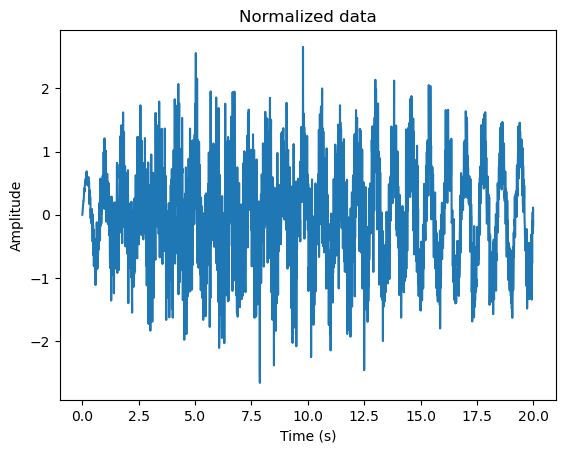

The share of points that are outside the 95% variability interval is 0.9199999999999999%
The share of y t+1 that are outside the 95% variability interval is 0.9199999999999999%


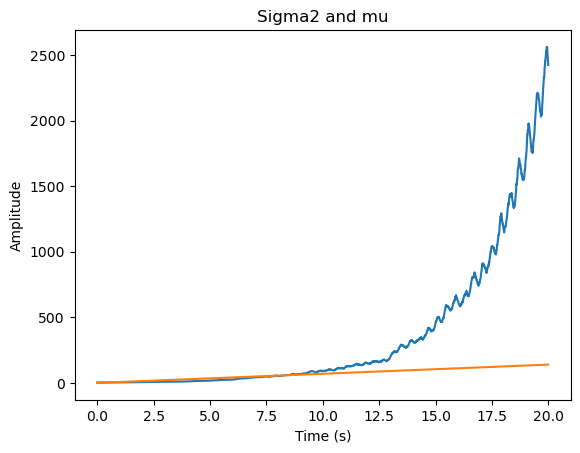

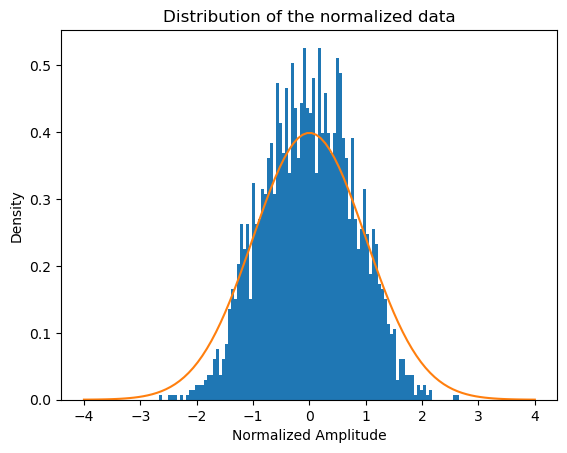

In [31]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np

#Set the normalization strngth for the mean and the variance from 0 to 1
mean_norm_strength = 0
var_norm_strength = 1

norm_strength = [mean_norm_strength*0.5, var_norm_strength*0.5]
#mu_list, sigma2_list, y_norm = SD_Normalization_Gaussian(y, y_train, 'Full', mode='predict', norm_strength=[0.5, 0.5])
mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(y, y_train,  mode='predict', norm_strength=norm_strength)



#Plot the normalized data

plt.plot(t[0:T], y_norm)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list+1.96*np.sqrt(sigma2_list), mode='lines', name='Upper Bound'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list-1.96*np.sqrt(sigma2_list), mode='lines', name='Lower Bound'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()


#Write the share of points that are outside the 95% variability interval

share = np.sum((y > mu_list+1.96*np.sqrt(sigma2_list)) | (y < mu_list-1.96*np.sqrt(sigma2_list)))/len(y)
print("The share of points that are outside the 95% variability interval is {}%".format(share*100))

#Write the share of y_{t+1} that are outside the 95% variability interval

share = np.sum((y[1:] > mu_list[0:-1]+1.96*np.sqrt(sigma2_list[0:-1])) | (y[1:] < mu_list[0:-1]-1.96*np.sqrt(sigma2_list[0:-1])))/len(y)
print("The share of y t+1 that are outside the 95% variability interval is {}%".format(share*100))

#Plot sigma_list and mu_list in the same plot
plt.plot(t[0:T], sigma2_list)
plt.plot(t[0:T], mu_list)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sigma2 and mu')
plt.show()

#Plot the distributino of the normalized and unormalized data and compare it with a standard normal distribution

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_norm, bins=100, density=True)
plt.plot(np.linspace(-4, 4, 100), stats.norm.pdf(np.linspace(-4, 4, 100), 0, 1))
plt.xlabel('Normalized Amplitude')
plt.ylabel('Density')
plt.title('Distribution of the normalized data')
plt.show()



In [32]:
#Redo the training with the new strategy
import Models
reload(Models)
from Models import GAS_Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_norm_train = y_norm[0:T_train]
y_norm_test = y_norm[T_train:T]

#Define the model, loss function, and optimizer and train it for 100 epochs.
#The training is divided in more phases to avoid gradients size problems.
#We first train only the mu layer to make linear predictions with mean information. All the rest is set to zero. 
#Then we fix the mu layer and train the nonlinear part. 
#Fianllly we train the sigma layer.


gas_net = GAS_Net()
gas_net.float()
gas_net.train()
criterion = nn.MSELoss()
model_parameters = gas_net.named_parameters()
optimizer_mu = optim.Adam([param for name, param in model_parameters if 'mu_layer' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_eps = optim.Adam([param for name, param in model_parameters if 'fc1' in name or 'fc2' in name or 'fc3' in name or 'relu' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_sigma = optim.Adam([param for name, param in model_parameters if 'sigma_layer' in name], weight_decay=1e-5)
optimizer_list = [optimizer_mu, optimizer_eps, optimizer_sigma]

for phase in range(2):
    optimizer = optimizer_list[phase]
    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, T_train - 200, 50):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs=y_norm_train[i:i+200]
            inputs = torch.tensor(inputs)
            labels = torch.tensor(y_train[i+200:i+250])
            mu_vector = torch.tensor(mu_list[i:i+200])
            sigma2_vector = torch.tensor(sigma2_list[i:i+200])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        print('[%d] loss: %.10f' %
                (epoch + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

[1] loss: 3279.8893661499
[2] loss: 1944.6117973328
[3] loss: 1438.6623783112
[4] loss: 1354.0958099365
[5] loss: 1328.2966995239
[6] loss: 1293.3314857483
[7] loss: 1284.0165119171
[8] loss: 1282.3795585632
[9] loss: 1275.2779006958
[10] loss: 1263.0829143524
[11] loss: 1249.1391696930
[12] loss: 1235.7381381989
[13] loss: 1223.7301387787
[14] loss: 1213.1640357971
[15] loss: 1203.8247890472
[16] loss: 1195.4385271072
[17] loss: 1187.7603120804
[18] loss: 1180.6700487137
[19] loss: 1174.2317914963
[20] loss: 1168.6515121460
[21] loss: 1164.1605701447
[22] loss: 1160.9190368652
[23] loss: 1158.9928903580
[24] loss: 1158.3963251114
[25] loss: 1159.1375036240
[26] loss: 1161.2147750854
[27] loss: 1164.4989414215
[28] loss: 1168.4511280060
[29] loss: 1171.7306618690
[30] loss: 1172.1056084633
[31] loss: 1167.4413666725
[32] loss: 1157.6658344269
[33] loss: 1145.4761366844
[34] loss: 1134.2801971436
[35] loss: 1125.8395977020
[36] loss: 1120.0988702774
[37] loss: 1116.2740335464
[38] loss:

In [33]:
#Test the model on the entire data set and plot the results.
gas_net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y_norm[i:i+200]
    inputs = torch.tensor(inputs)
    mu_vector = torch.tensor(mu_list[i:i+200])
    sigma2_vector = torch.tensor(sigma2_list[i:i+200])
    outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 1)
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)

#plot with plotly with a line where the training set ends

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.

error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

394.93447360714936


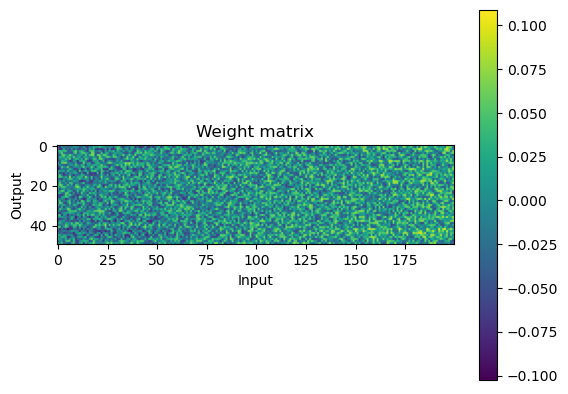

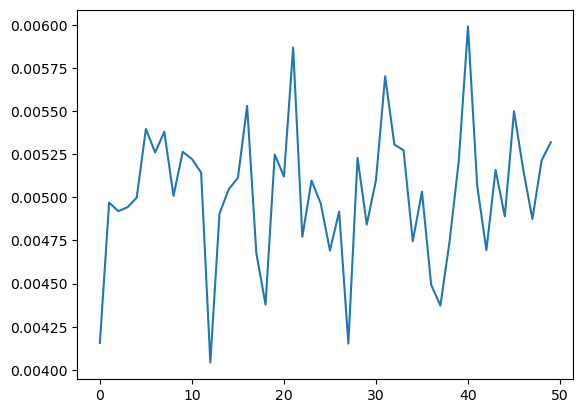

In [34]:
#Plot the weight matrix of the last layer of the network as an heatmap and add the legend of the colorbar

weights = gas_net.mu_layer.weight.detach().numpy()
plt.imshow(weights)
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Weight matrix')

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.mu_layer.weight.detach().numpy()
plt.plot(weights.mean(axis=1))






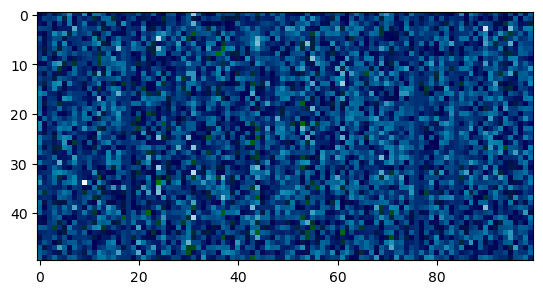

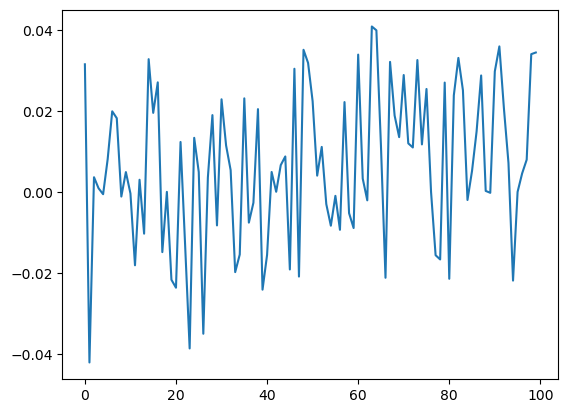

In [35]:
#Plot the weight matrix of the last layer of the network as an heatmap

weights = gas_net.fc3.weight.detach().numpy()
plt.imshow(weights, interpolation='nearest', cmap=plt.cm.ocean)

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.fc3.weight.detach().numpy()
plt.plot(weights.mean(axis=0))


In [36]:
#Define a neural network class that use Revin as normalization procedure
#Revin expect the input and output to be (batch, time, features) so we need to reshape the data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


In [37]:
import Models
reload(Models)
from Models import Revin_Net


#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Revin_Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
net.train()

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1] loss: 1213.5760650635
[2] loss: 433.0062904358
[3] loss: 327.7582335472
[4] loss: 283.3299872875
[5] loss: 255.3570297956
[6] loss: 229.1443953514
[7] loss: 206.0106015205
[8] loss: 183.6314883232
[9] loss: 160.7752273083
[10] loss: 138.6532634497
[11] loss: 123.5617455244
[12] loss: 103.9996101856
[13] loss: 88.9789781570
[14] loss: 100.6417735219
[15] loss: 82.9594533443
[16] loss: 112.6459421515
[17] loss: 151.6927957535
[18] loss: 135.8631973863
[19] loss: 174.5146441460
[20] loss: 107.3320649862
[21] loss: 121.2606482506
[22] loss: 63.1824971884
[23] loss: 52.1377874613
[24] loss: 45.5816176981
[25] loss: 40.7977349609
[26] loss: 31.9763785452
[27] loss: 31.3846450225
[28] loss: 30.2138740122
[29] loss: 30.1582637876
[30] loss: 25.5400940180
[31] loss: 26.9735696018
[32] loss: 24.6003858224
[33] loss: 26.4422025084
[34] loss: 22.5931600481
[35] loss: 25.6985901296
[36] loss: 22.5838230178
[37] loss: 27.1855922341
[38] loss: 24.2983982861
[39] loss: 28.4438928962
[40] loss: 28.

In [38]:
#Test the model on the entire data set and plot the results.
net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T - 200)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

316.6610996577517


## Autoregressive GAS Test

In [39]:
#Redo the training with the new strategy
import Models
reload(Models)
from Models import AR_GAS_Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_norm_train = y_norm[0:T_train]
y_norm_test = y_norm[T_train:T]

#Define the model, loss function, and optimizer and train it for 100 epochs.
#The training is divided in more phases to avoid gradients size problems.
#We first train only the mu layer to make linear predictions with mean information. All the rest is set to zero. 
#Then we fix the mu layer and train the nonlinear part. 
#Fianllly we train the sigma layer.


ar_gas_net = AR_GAS_Net(k = 50, use_deep_preds=False)
ar_gas_net.float()
ar_gas_net.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(ar_gas_net.parameters(), weight_decay=1e-5)

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs=y_norm_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])
        last_mu = torch.tensor(mu_list[i+199])
        last_sigma2 = torch.tensor(sigma2_list[i+199])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = ar_gas_net(inputs.float(), last_mu.float(), last_sigma2.float(), alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

[1] loss: 459.0734786987
[2] loss: 334.5992535353
[3] loss: 242.9974173307
[4] loss: 198.2058398724
[5] loss: 167.0037757158
[6] loss: 137.6615132093
[7] loss: 111.6293261051
[8] loss: 87.9811810255
[9] loss: 73.4941526651
[10] loss: 66.3349156380
[11] loss: 65.7646176815
[12] loss: 62.2475670576
[13] loss: 76.9761490822
[14] loss: 58.6302536726
[15] loss: 57.4222170115
[16] loss: 36.6829149723
[17] loss: 35.6005977392
[18] loss: 26.9529591203
[19] loss: 26.5593855977
[20] loss: 22.7647546232
[21] loss: 22.2501371503
[22] loss: 20.8930384517
[23] loss: 21.0538745224
[24] loss: 19.6515362263
[25] loss: 19.3471007645
[26] loss: 19.5687987506
[27] loss: 20.0758434534
[28] loss: 23.3018307686
[29] loss: 22.5390520990
[30] loss: 48.6162801385
[31] loss: 33.6561279893
[32] loss: 58.8358231187
[33] loss: 26.3533042222
[34] loss: 52.9166988432
[35] loss: 21.9086660296
[36] loss: 39.5957804471
[37] loss: 24.0857942402
[38] loss: 44.1582429558
[39] loss: 18.8743204176
[40] loss: 26.2673231885
[4

In [40]:
#Test the model on the entire data set and plot the results.
ar_gas_net.eval()
y_pred = []

for i in range(0, T - 200, 50):
    inputs=y_norm[i:i+200]
    inputs = torch.tensor(inputs)
    last_mu = torch.tensor(mu_list[i+199])
    last_sigma2 = torch.tensor(sigma2_list[i+199])
    outputs = ar_gas_net(inputs.float(), last_mu.float(), last_sigma2.float(), alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

181.4745939170011
